In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [2]:
pwd

'/Users/Saurbier/Desktop/appttrader/Other'

In [3]:
dcl = pd.read_csv('../../../downloads/dcl_data.csv')

In [4]:
dcl

,Active Day,Active Users
0,2019-06-22,2
1,2019-06-24,3
2,2019-06-25,7
3,2019-06-26,12
4,2019-06-27,14
...,...,...
1196,2022-10-01,4169
1197,2022-10-02,3998
1198,2022-10-03,4655
1199,2022-10-04,4915


In [5]:
ticker_symbol = "MANA-USD"
mana = yf.download(ticker_symbol, start="2019-06-22", end="2023-12-31", interval="1d")


[*********************100%%**********************]  1 of 1 completed


In [6]:
mana

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-06-22,0.055885,0.057014,0.053759,0.055394,0.055394,12236291
2019-06-23,0.055392,0.058420,0.053165,0.053927,0.053927,12495176
2019-06-24,0.053927,0.056241,0.053012,0.054048,0.054048,10111803
2019-06-25,0.054071,0.055577,0.051697,0.052092,0.052092,12051718
2019-06-26,0.052092,0.054534,0.048620,0.049772,0.049772,14542780
...,...,...,...,...,...,...
2023-12-26,0.560997,0.604545,0.529904,0.559189,0.559189,239104790
2023-12-27,0.559204,0.562697,0.532477,0.555388,0.555388,106282847
2023-12-28,0.555524,0.564097,0.523568,0.530170,0.530170,99798303


In [7]:
dcl.dtypes

Active Day      object
Active Users     int64
dtype: object

In [8]:
mana.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [9]:
#rename
dcl.rename(columns={'Active Day': 'Date'}, inplace=True)

# obj to dt
dcl['Date'] = pd.to_datetime(dcl['Date'])

#reset index
mana = mana.reset_index()
mana['Date'] = pd.to_datetime(mana['Date'])

In [10]:
dcl.dtypes

Date            datetime64[ns]
Active Users             int64
dtype: object

In [11]:
mana.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [12]:
df = pd.merge(dcl, mana, on='Date', how='inner')


In [13]:
df

,Date,Active Users,Open,High,Low,Close,Adj Close,Volume
0,2019-06-22,2,0.055885,0.057014,0.053759,0.055394,0.055394,12236291
1,2019-06-24,3,0.053927,0.056241,0.053012,0.054048,0.054048,10111803
2,2019-06-25,7,0.054071,0.055577,0.051697,0.052092,0.052092,12051718
3,2019-06-26,12,0.052092,0.054534,0.048620,0.049772,0.049772,14542780
4,2019-06-27,14,0.049887,0.050541,0.043689,0.045408,0.045408,11212750
...,...,...,...,...,...,...,...,...
1196,2022-10-01,4169,0.698128,0.702553,0.691854,0.693072,0.693072,61036195
1197,2022-10-02,3998,0.693102,0.696785,0.681832,0.682872,0.682872,70828324
1198,2022-10-03,4655,0.682869,0.697688,0.677542,0.696955,0.696955,100801265
1199,2022-10-04,4915,0.696968,0.707431,0.693442,0.704043,0.704043,100628912


In [14]:
df.isna().sum()

Date            0
Active Users    0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
dtype: int64

# predictions

In [15]:
def create_lagged_features(df, max_lag):
    """
    Creates lagged features for a given DataFrame and maximum number of lags.
    """
    lagged_columns = []
    for lag in range(1, max_lag + 1):
        lagged_col_name = f'Adj Close Lag {lag}'
        lagged_column = df['Adj Close'].shift(lag)
        df[lagged_col_name] = lagged_column
        lagged_columns.append(lagged_col_name)
    
    return df, lagged_columns

# Example usage with a max_lag of 10
df, lagged_columns = create_lagged_features(df, 10)
df = df.dropna() 

In [16]:
# Define the target and features
max_lag = 10  # or any other number you used in create_lagged_features
y = df['Adj Close']
X = df.drop(['Date', 'Adj Close'] + lagged_columns[-max_lag:], axis=1)  # Excluding the most recent lagged variables to prevent data leakage

# Time-based split
# Assuming that 80% of the data is for training and the rest for testing
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [85]:
pipeline = Pipeline([('regressor', xgb.XGBRegressor(objective ='reg:squarederror'))])

param_grid = {
    'regressor__colsample_bytree': np.linspace(0.1, .9, 10),
    'regressor__learning_rate': np.linspace(0.01, .4, 50),
    'regressor__max_depth': range(1,10,1),
    'regressor__alpha': range(2,20, 3),
    'regressor__n_estimators': range(20,401, 100)
}

random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=100, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END regressor__alpha=11, regressor__colsample_bytree=0.9, regressor__learning_rate=0.04489795918367347, regressor__max_depth=5, regressor__n_estimators=20; total time=   0.0s
[CV] END regressor__alpha=17, regressor__colsample_bytree=0.7222222222222222, regressor__learning_rate=0.01, regressor__max_depth=1, regressor__n_estimators=120; total time=   0.0s
[CV] END regressor__alpha=17, regressor__colsample_bytree=0.7222222222222222, regressor__learning_rate=0.01, regressor__max_depth=1, regressor__n_estimators=120; total time=   0.0s
[CV] END regressor__alpha=5, regressor__colsample_bytree=0.8111111111111111, regressor__learning_rate=0.09142857142857143, regressor__max_depth=5, regressor__n_estimators=320; total time=   0.0s
[CV] END regressor__alpha=5, regressor__colsample_bytree=0.8111111111111111, regressor__learning_rate=0.09142857142857143, regressor__max_depth=5, regressor__n_estimators=320; total time=   0.1s
[CV] 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('regressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_co...
       0.24877551, 0.25673469, 0.26469388, 0.27265306, 0.28061224,
       0.28857143, 0.29653061, 0.3044898 , 0.31244898, 0.32040816,
       0.32836735, 0.33632653, 0.34428571, 0.3522449 , 0.36020408,
       0.36816327, 0.37612245, 0.38408163, 0.39204082, 0.4       ]),
                                        'regressor__max_depth': range(1, 10),
                                        'regressor__n_estimators': range(20, 401, 100)},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [86]:
best_params = random_search.best_params_

best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=best_params['regressor__colsample_bytree'],
    learning_rate=best_params['regressor__learning_rate'],
    max_depth=best_params['regressor__max_depth'],
    alpha=best_params['regressor__alpha'],
    n_estimators=best_params['regressor__n_estimators']
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error with Best Hyperparameters: {mse}')


Mean Squared Error with Best Hyperparameters: 0.006484694231290525


In [89]:
from sklearn.metrics import r2_score

# ... [your existing code for fitting the model and making predictions] ...

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared with Best Hyperparameters: {r2}')


R-squared with Best Hyperparameters: 0.9891872598826787


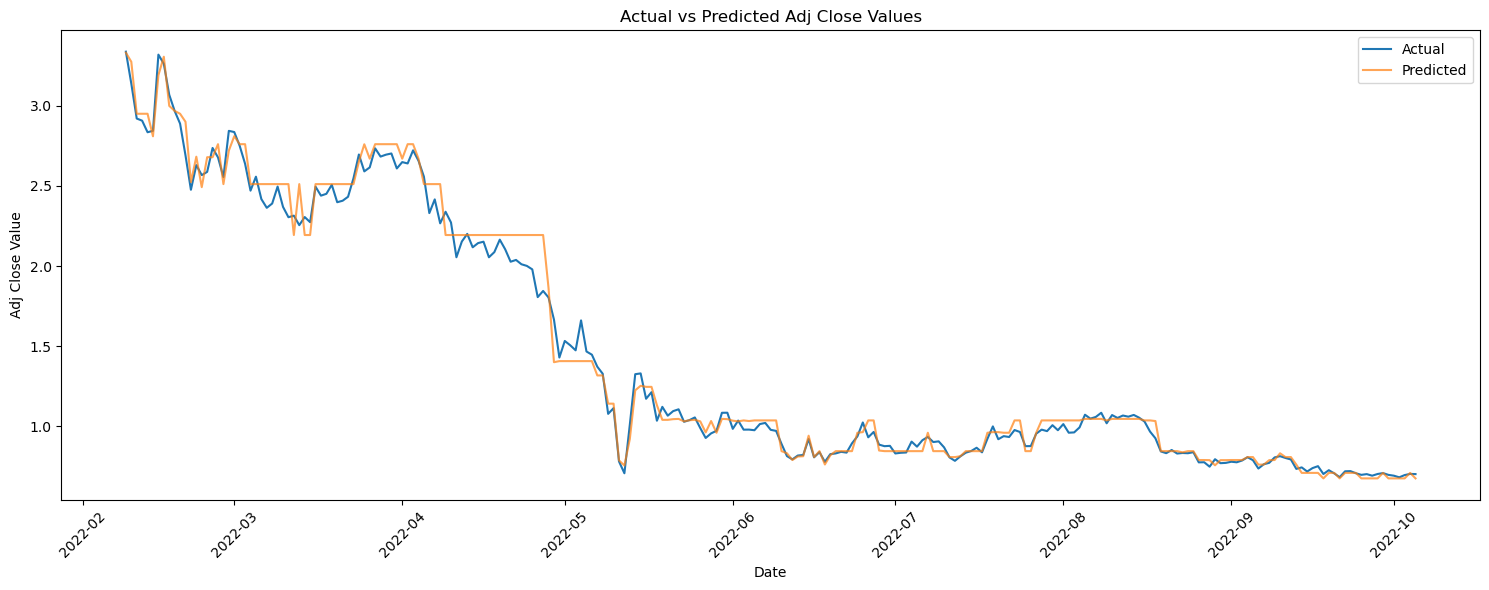

In [88]:
test_dates = df.loc[X_test.index, 'Date']

actual_df = y_test.reset_index(drop=True)
pred_df = pd.DataFrame(y_pred, columns=['Predicted Adj Close'])
result_df = pd.concat([test_dates.reset_index(drop=True), actual_df, pred_df], axis=1)

result_df.sort_values(by='Date', inplace=True)


plt.figure(figsize=(15, 6))
plt.plot(result_df['Date'], result_df['Adj Close'], label='Actual')
plt.plot(result_df['Date'], result_df['Predicted Adj Close'], label='Predicted', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Adj Close Value')
plt.title('Actual vs Predicted Adj Close Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

# causal inference

In [20]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['t-stat','p-value'])
    return dfoutput

In [21]:
interpret_dftest(adfuller(df['Adj Close']))

t-stat    -1.807886
p-value    0.376554
dtype: float64

In [22]:
interpret_dftest(adfuller(df['Adj Close'].diff().dropna()))

t-stat    -6.982689e+00
p-value    8.115535e-10
dtype: float64

In [24]:
# remove unit root

df_diff = pd.DataFrame()

df_diff['Date'] = df['Date']

columns_to_difference = df.columns.drop('Date')

for column in columns_to_difference:
    df_diff[column] = df[column].diff()

df_diff = df_diff.dropna()


In [25]:


def check_stationarity(series, significance_level=0.05):
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    if p_value < significance_level:
        print(f"Series {column} is stationary (p-value: {p_value})")
    else:
        print(f"Series {column} is not stationary (p-value: {p_value})")

# Example usage for each series in df_diff
for column in df_diff.columns:
    check_stationarity(df_diff[column])


/Users/Saurbier/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:956: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


Series Date is not stationary (p-value: 0.9912284932771066)
Series Active Users is stationary (p-value: 3.1623928386684175e-28)
Series Open is stationary (p-value: 7.348444245206798e-15)
Series High is stationary (p-value: 1.9072617597995542e-15)
Series Low is stationary (p-value: 4.172045907862063e-12)
Series Close is stationary (p-value: 8.115534892411149e-10)
Series Adj Close is stationary (p-value: 8.115534892411149e-10)
Series Volume is stationary (p-value: 8.821466107850788e-21)
Series Adj Close Lag 1 is stationary (p-value: 8.106338305245716e-10)
Series Adj Close Lag 2 is stationary (p-value: 8.131836444430525e-10)
Series Adj Close Lag 3 is stationary (p-value: 8.188678507175855e-10)
Series Adj Close Lag 4 is stationary (p-value: 8.169819361726943e-10)
Series Adj Close Lag 5 is stationary (p-value: 8.173133338066839e-10)
Series Adj Close Lag 6 is stationary (p-value: 8.160068915157354e-10)
Series Adj Close Lag 7 is stationary (p-value: 8.168098603341214e-10)
Series Adj Close Lag

In [26]:
df_diff

,Date,Active Users,Open,High,Low,Close,Adj Close,Volume,Adj Close Lag 1,Adj Close Lag 2,Adj Close Lag 3,Adj Close Lag 4,Adj Close Lag 5,Adj Close Lag 6,Adj Close Lag 7,Adj Close Lag 8,Adj Close Lag 9,Adj Close Lag 10
11,2019-07-04,2.0,0.006918,0.005970,0.005743,0.006156,0.006156,16880508.0,0.007088,-0.001995,-0.000899,-0.001099,0.003615,0.001296,-0.004364,-0.002320,-0.001956,-0.001346
12,2019-07-05,-2.0,0.006147,-0.001973,0.002149,-0.005192,-0.005192,-16118542.0,0.006156,0.007088,-0.001995,-0.000899,-0.001099,0.003615,0.001296,-0.004364,-0.002320,-0.001956
13,2019-07-06,-8.0,-0.005181,-0.010154,-0.002708,-0.002617,-0.002617,-11894729.0,-0.005192,0.006156,0.007088,-0.001995,-0.000899,-0.001099,0.003615,0.001296,-0.004364,-0.002320
14,2019-07-07,1.0,-0.002486,-0.000373,0.000009,0.000266,0.000266,-1553034.0,-0.002617,-0.005192,0.006156,0.007088,-0.001995,-0.000899,-0.001099,0.003615,0.001296,-0.004364
15,2019-07-08,5.0,0.000160,-0.001607,-0.002145,-0.000243,-0.000243,874122.0,0.000266,-0.002617,-0.005192,0.006156,0.007088,-0.001995,-0.000899,-0.001099,0.003615,0.001296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,2022-10-01,-837.0,-0.011116,-0.013371,-0.001808,-0.005069,-0.005069,-71670066.0,-0.011100,0.005615,0.010570,-0.009771,0.004521,-0.009906,-0.013286,0.001065,0.036552,-0.023490
1197,2022-10-02,-171.0,-0.005026,-0.005768,-0.010022,-0.010200,-0.010200,9792129.0,-0.005069,-0.011100,0.005615,0.010570,-0.009771,0.004521,-0.009906,-0.013286,0.001065,0.036552
1198,2022-10-03,657.0,-0.010233,0.000903,-0.004290,0.014083,0.014083,29972941.0,-0.010200,-0.005069,-0.011100,0.005615,0.010570,-0.009771,0.004521,-0.009906,-0.013286,0.001065
1199,2022-10-04,260.0,0.014099,0.009743,0.015900,0.007088,0.007088,-172353.0,0.014083,-0.010200,-0.005069,-0.011100,0.005615,0.010570,-0.009771,0.004521,-0.009906,-0.013286


In [27]:
df_diff = df_diff.dropna()

In [28]:
df_inf = df_diff.iloc[:, :8]

In [29]:
df_inf = df_inf.drop(columns = ['Open', 'High', "Low", "Close"])

In [30]:
df_inf

,Date,Active Users,Adj Close,Volume
11,2019-07-04,2.0,0.006156,16880508.0
12,2019-07-05,-2.0,-0.005192,-16118542.0
13,2019-07-06,-8.0,-0.002617,-11894729.0
14,2019-07-07,1.0,0.000266,-1553034.0
15,2019-07-08,5.0,-0.000243,874122.0
...,...,...,...,...
1196,2022-10-01,-837.0,-0.005069,-71670066.0
1197,2022-10-02,-171.0,-0.010200,9792129.0
1198,2022-10-03,657.0,0.014083,29972941.0
1199,2022-10-04,260.0,0.007088,-172353.0


In [33]:
df_vif = df_inf.reset_index(drop=True)
df_vif_numeric = df_vif.select_dtypes(include=[np.number])  # Select only numeric columns

# Initialize DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif_numeric.columns

# Calculate VIF for each numeric variable
vif_data["VIF"] = [variance_inflation_factor(df_vif_numeric.values, i) for i in range(df_vif_numeric.shape[1])]

print(vif_data)

        feature       VIF
0  Active Users  1.027337
1     Adj Close  1.887507
2        Volume  1.888976


In [34]:
# "Causality", "predictivity"
max_lag = 10  
test = 'ssr_chi2test'  # Test method
causality_df_1 = grangercausalitytests(df_diff[['Adj Close', 'Active Users']], max_lag, verbose=True)
causality_df_2 = grangercausalitytests(df_diff[['Active Users', 'Adj Close']], max_lag, verbose=True)

/Users/Saurbier/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0015  , p=0.0834  , df_denom=1186, df_num=1
ssr based chi2 test:   chi2=3.0091  , p=0.0828  , df=1
likelihood ratio test: chi2=3.0053  , p=0.0830  , df=1
parameter F test:         F=3.0015  , p=0.0834  , df_denom=1186, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1929  , p=0.0414  , df_denom=1183, df_num=2
ssr based chi2 test:   chi2=6.4127  , p=0.0405  , df=2
likelihood ratio test: chi2=6.3955  , p=0.0409  , df=2
parameter F test:         F=3.1929  , p=0.0414  , df_denom=1183, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6076  , p=0.0130  , df_denom=1180, df_num=3
ssr based chi2 test:   chi2=10.8871 , p=0.0124  , df=3
likelihood ratio test: chi2=10.8375 , p=0.0126  , df=3
parameter F test:         F=3.6076  , p=0.0130  , df_denom=1180, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.2393  , p=0.

/Users/Saurbier/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


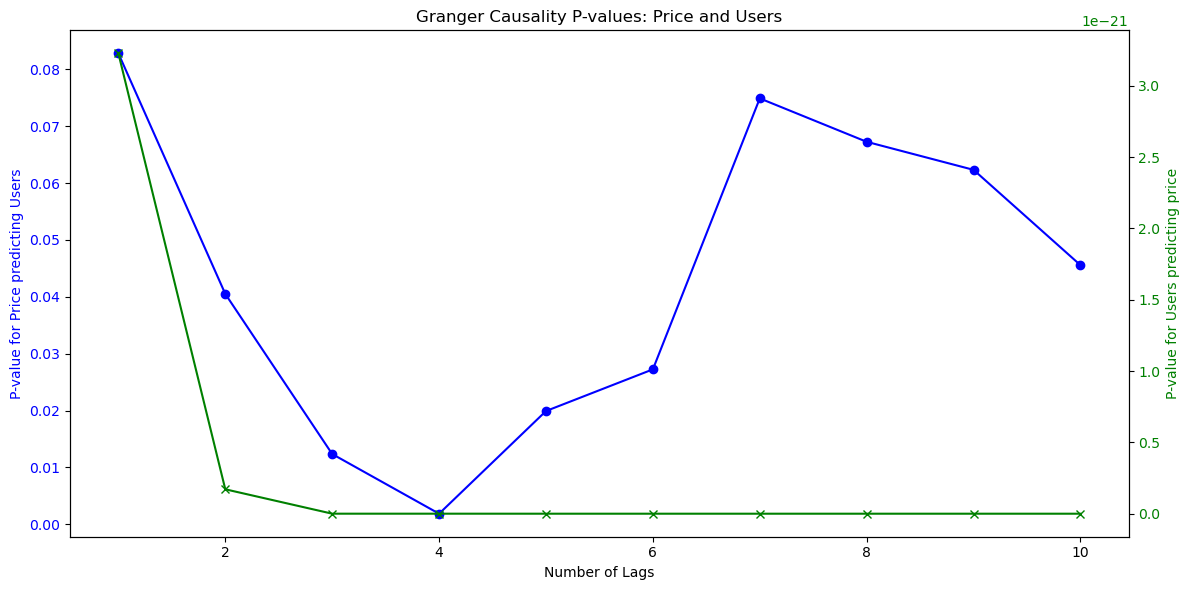

In [35]:
def extract_p_values(causality_results, max_lag, test):
    p_values = []
    for lag in range(1, max_lag + 1):
        p_value = causality_results[lag][0][test][1]  # Extracting the p-value
        p_values.append(p_value)
    return p_values

p_values_adj_close = extract_p_values(causality_df_1, max_lag, test)
p_values_active_users = extract_p_values(causality_df_2, max_lag, test)

lags = range(1, max_lag + 1)
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(lags, p_values_adj_close, 'o-', color='blue', label="'Price predicting Users")
ax1.set_xlabel('Number of Lags')
ax1.set_ylabel('P-value for Price predicting Users', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(lags, p_values_active_users, 'x-', color='green', label="Users predicting Price")
ax2.set_ylabel('P-value for Users predicting price', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1.set_title("Granger Causality P-values: Price and Users")
fig.tight_layout()

plt.show()

In [36]:
df_inf = df_inf.set_index('Date')

df_inf.index = pd.to_datetime(df_inf.index)

model = VAR(df_inf)
results = model.fit(maxlags=max_lag, ic='aic')  # 'aic' for Akaike Information Criterion to select best lag

print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, Jan, 2024
Time:                     07:29:33
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    49.8992
Nobs:                     1180.00    HQIC:                   49.6501
Log likelihood:          -34134.7    FPE:                3.14288e+21
AIC:                      49.4994    Det(Omega_mle):     2.90764e+21
--------------------------------------------------------------------
Results for equation Active Users
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    5.872539        26.092960            0.225           0.822
L1.Active Users         -0.181900         0.029954           -6.073           0.000
L1.Adj Close          2578.409346       3

/Users/Saurbier/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


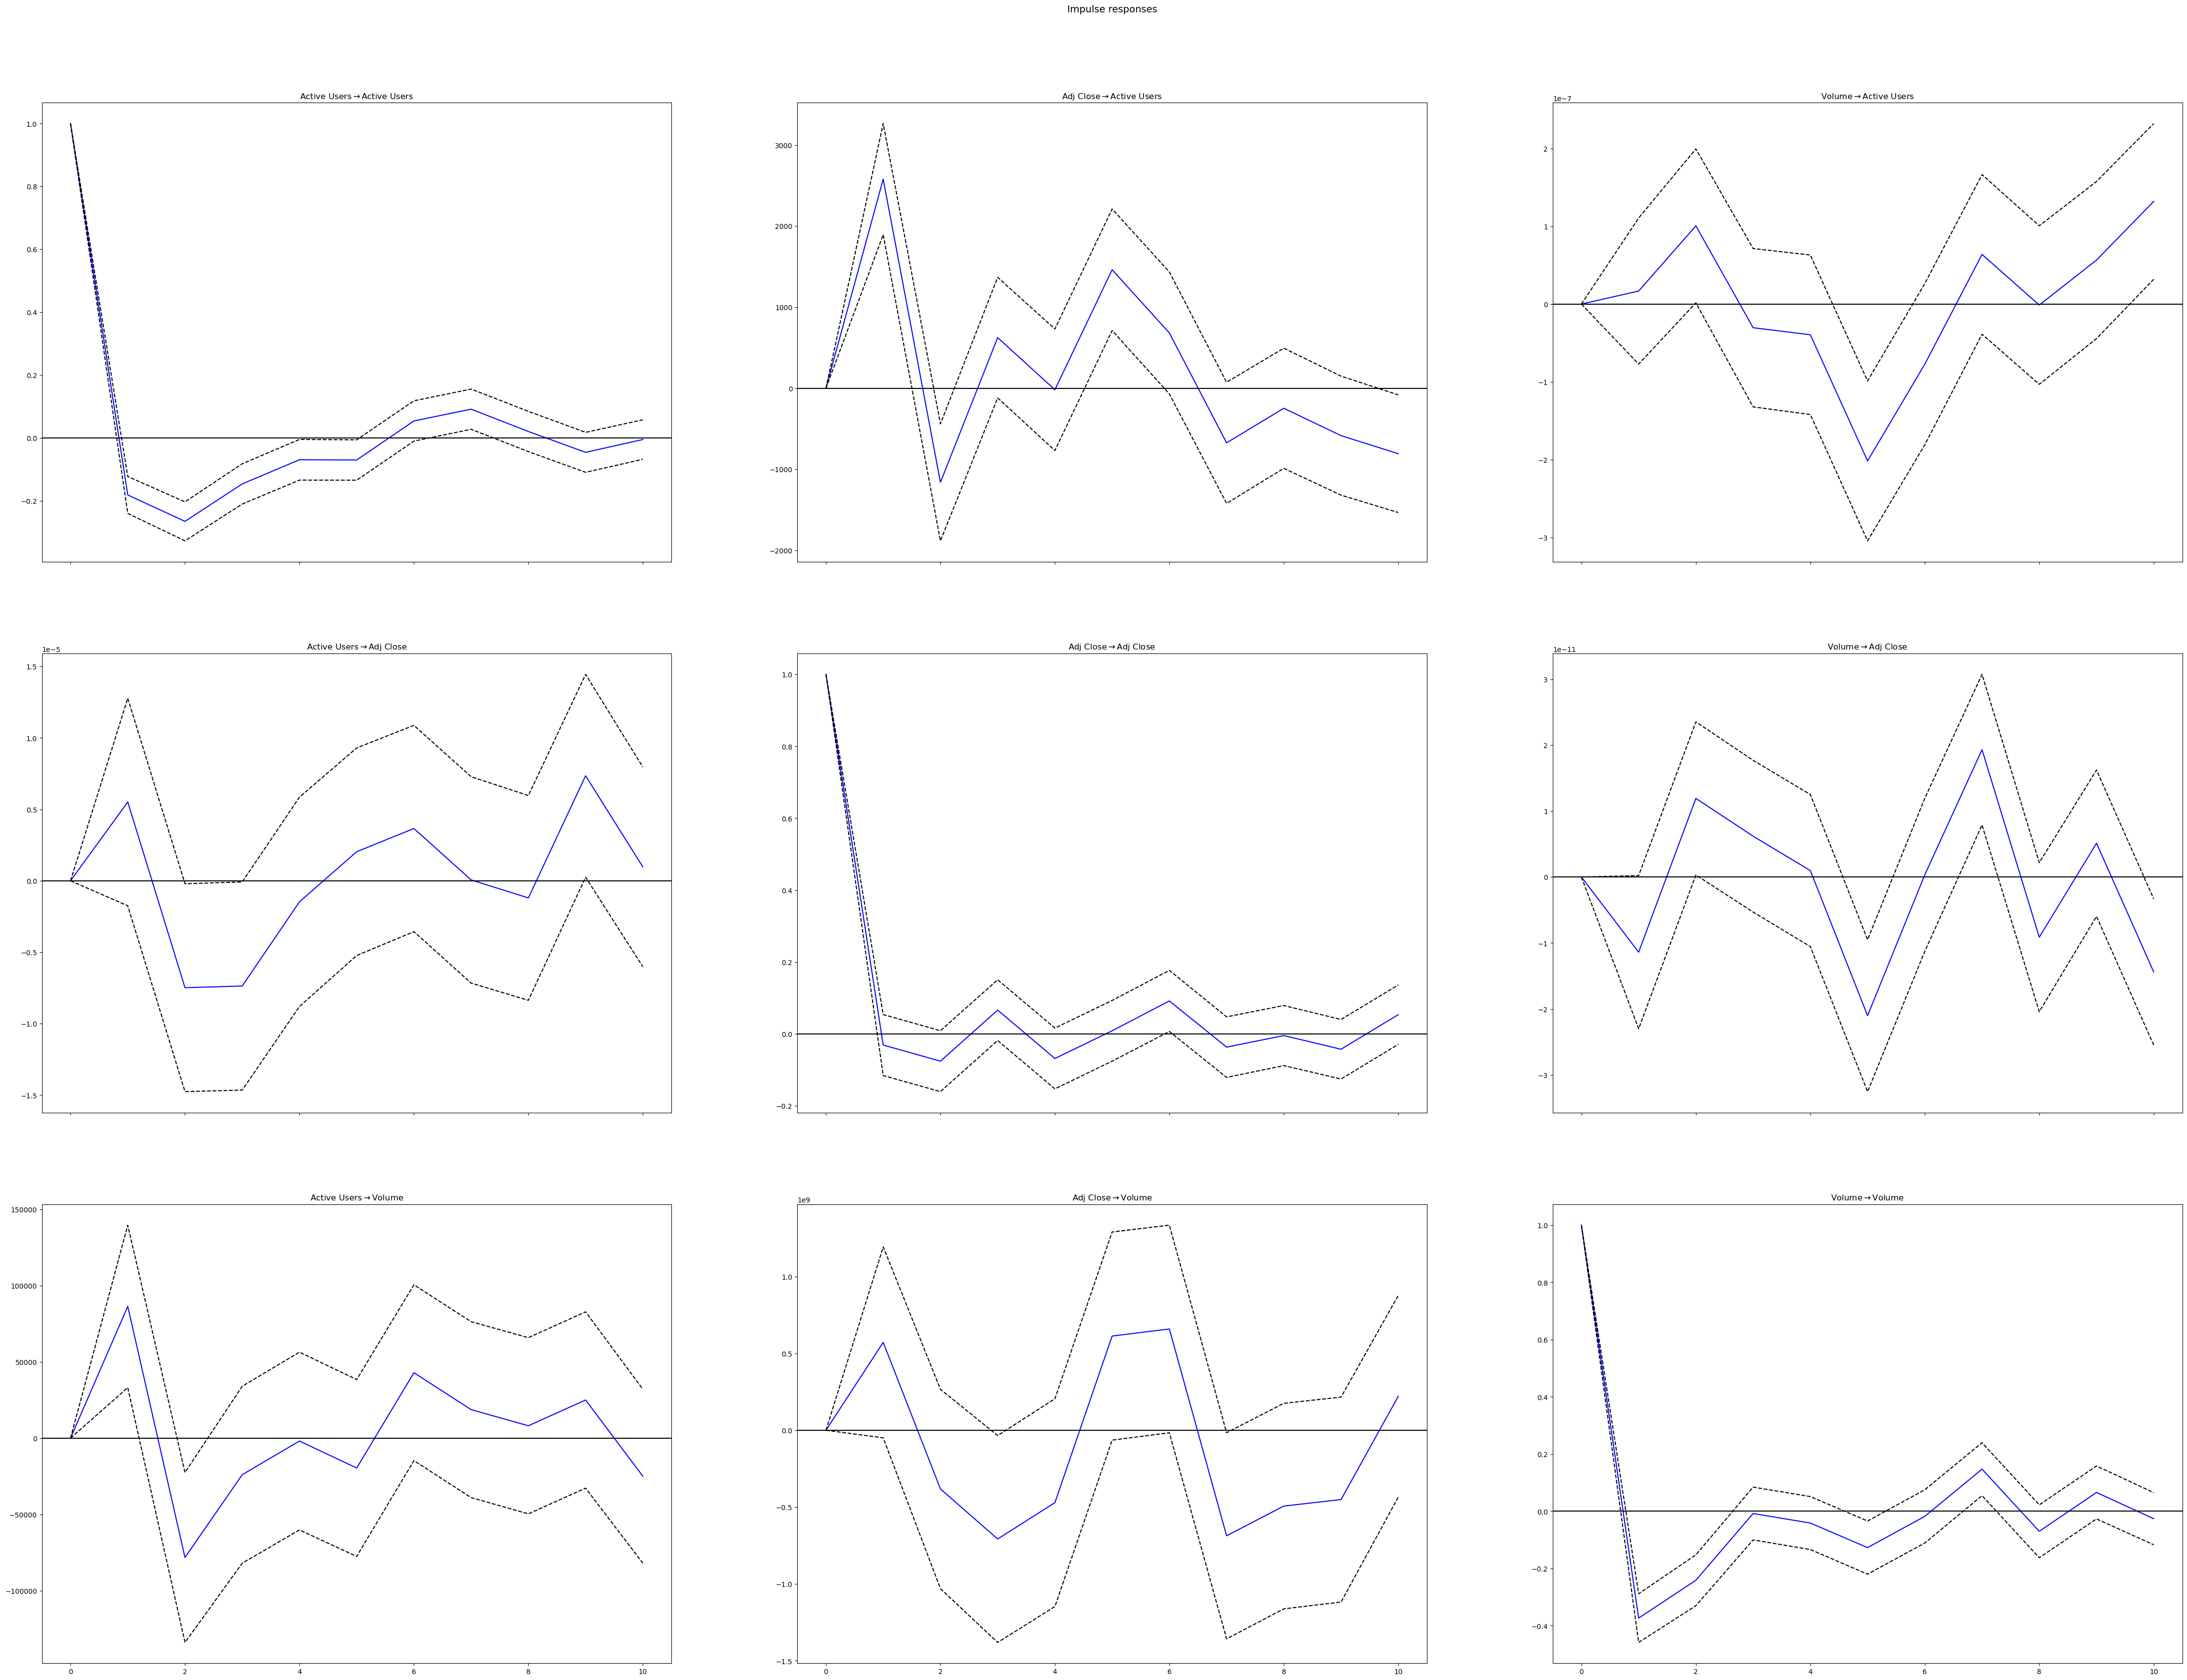

In [37]:
irf = results.irf(periods=10)  

# Create IRF plots with increased size
irf.plot(orth=False, figsize=(48, 36))  
plt.savefig('irf_plot.png')